# **CT5133 Deep Learning - Assignment 2:**
## Unsupervised/self-supervised learning and generating images in Keras
**Submitted By:** Kalyani Prashant Kawale

**Student ID:** 21237189


## **Initial Setup**:

Setting dataset directory and loading libraries.

In [1]:
# Mounting the google drive to load dataset stored in the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting the path to the directory containing dataset
%cd drive/MyDrive/Colab Notebooks/DeepLearning/Assignment2

/content/drive/MyDrive/Colab Notebooks/DeepLearning/Assignment2


In [3]:
# Loading required libraries
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import glob
import imageio
import PIL
import time
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.losses import mse
from keras import backend as K
from IPython import display

%matplotlib inline

## **Section 1: Data-Set**

* The data-set selected to train the unsupervised learning models to generate new images is **Devanagari Handwritten Character Dataset Data Set** [1, 2].
* Created to help benchmark classification algorithm for OCR systems, the data-set consists of 32x32 png images of handwritten devanagari characters, which is the alphabet for Indian langugaes like Hindi and Marathi [2].
* The data-set has been made available by [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) [3] and can be downloaded from  [Devanagari Handwritten Character Dataset](https://archive.ics.uci.edu/ml/datasets/Devanagari+Handwritten+Character+Dataset) [2].



### 1.1 Possible Application:

* Natural languages that use devanagari script are relatively under-resourced languages.
* However, as these are also widely spoken, images generated for the characters could be used in teaching applications such as Duolingo, to display the characters to help aid the learning process.
* While, character codes do exist for devanagari characters, the images generated on the go by an image generator could be much more useful in applications other than teaching tools as well, such as translation applications.

### 1.2 Dataset Loading and Preprocessing:

* The dataset [1], originally intended for use in classification tasks, has 92000 instances, distributed across number of labelled directories, thus, for the given task a smaller dataset has been created without the labels.
* The smaller dataset has ---- instances, and is loaded using OpenCV library in following sections.

> **Creating a list of image file names**:
> The *images* list is created to store the image file names, to be shuffled, and used to load the images according to the shuffled list.

In [4]:
# Saving image file names along with directory name in images list
# path = './weather'
# path = './animal_sketches'
# path = './devanagari_letters'
path = './devanagari_letters_more'

images = [os.path.join(path, img) for img in os.listdir(path)]

In [5]:
# Shuffling the images list and setting seed for reproducibility
np.random.seed(200)
np.random.shuffle(images)

In [70]:
# Reading the png images from directory and resizing to 32x32,
# to ensure all images have same fixed size
img_array = []
for img in images:
  try:
    img_array.append(cv2.resize(cv2.imread(img), (32, 32)))
  except:
    # Skipping errorneous images 
    pass

> **Plotting first 9 images from the dataset in 3x3 grid:**

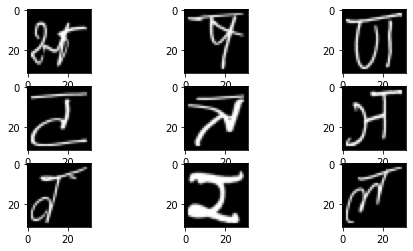

In [71]:
# Setting the plot size
fig = plt.figure(figsize=(8, 4))
# Specifying number of rows and columns,
# to show images in 3x3 grid
columns = 3
rows = 3
# Setting the position of images in the grid
for index, img in enumerate(img_array[0:9]):
  fig.add_subplot(rows, columns, index+1)
  plt.imshow(img)
# Displaying the images  
plt.show()

In [83]:
dataset = np.array(img_array)/255 # Normalizing image pixels between 0 to 1

In [84]:
dataset = tf.cast(img_array, tf.float32) # Converting the images into Tensorflow compatible format

## **Section 2: Building Auto-Encoder, Variational Auto-Encoder, and Generative Adversarial Network**

### 2.1 Network Architecture:

* For building comparative image generators using autoencoder (AE), variational autoencoder (VAE) and generative adversarial network (GAN), following common Keras layers has been configured for main computation in each model according to the model's design requirements:

  1. A 2D Convolutional layer with 16 filters and a 3x3 kernel, with stride set to 1.
  2. A 2D Convolutional layer with 32 filters and a 3x3 kernel, with stride set to 1.
  3. A 2D Convolutional layer with 64 filters and a 3x3 kernel, with stride set to 1.

* Each of the above layer used the Leaky Rectified Linear Unit activation function configured using Keras's LeakyReLU layer.

* Apart from these, Input, Dense, Flatten, Reshape layers and a custom Sampling layer are used to handle inputs, outputs and sampling from latent space.

* All the models use an Adam optimizer with 0.001 learning rate for training, and the training is ran for 20 epochs and 200 batch size.


### 2.2 Common Settings:

> **Initializing common settings**:

In [74]:
# Setting input and latent space dimensions
image_dim = (32, 32, 3)
latent_dim = 100
# Setting the epochs and batch size for model training
EPOCHS = 20
BATCH_SIZE = 200

> **Defining a common method for performing & displaying reconstructed images**: The autoencoder and variational autoencoder are trained primarily to generate their input as output, thus, a trained AE or VAE model can be used to reconstruct the input images using the model **predict** method as follows,

In [13]:
# Following code is based on plot_compare method taken from [9]
def reconstruct_results(generation_model, model, num_images=5, start=0):
  """
    Method to reconstruct input image using autoencoder
    params::generation_model: trained autoencoder or variational autoencoder
    params::model: name of the model
    params::num_images: number of images to be reconstructed
    params::start: start index of image in the dataset
  """
  # Sampling num_images number of images from the dataset
  sample_images = dataset[start:(start + num_images)]
  
  # Using the autoencoder/vae to reconstruct images using predict method
  reconstructed_imgs = generation_model.predict(sample_images)
  
  # Configuring figure to plot images
  img_len = len(sample_images)
  fig = plt.figure(figsize=(num_images + 3, 4))  

  # Configuring to plot the sampled dataset images
  for i in range(img_len):
    # Setting image position in plot
    sub = fig.add_subplot(2, img_len, i+1)
    sub.axis('off')
    sub.imshow(sample_images[i])

  # Configuring to plot the reconstructed images below the original images
  for i in range(img_len):
    # Setting image position in plot
    sub = fig.add_subplot(2, img_len, i+img_len+1)
    sub.axis('off')
    sub.imshow(reconstructed_imgs[i])
  # Saving the plot as png  
  plt.savefig(f'{model}_reconstruct_images.png')

> **Defining a common method to generate and display new samples**: The autoencoders are trained to generate output which is nothing but the input itself and the GAN trains its generator and discriminator to classify between fake and real images, during these trainings the decoder and the generator trained in the process become capable of creating new images from low-dimensional data. The following method is defined to use the **predict** method on decoder and/or generator to generate new sample images, which are then displayed in a 3x3 grid,

In [58]:
# Following plotting logic taken from [10]
def generate_images(img_generator, model, latent_dim, num_images=9):
  """
    Method to generate new images
    params::img_generator: trained decoder or generator
    params::model: name of the model
    params::latent_dim: dimension of the latent space
    params::num_images: number of images to be reconstructed    
  """
  # Generating new images using img_generator, 
  # which is decoder in case of autoencoder and vae
  # and generator in case of GAN
  new_images = img_generator.predict(np.random.normal(0, 1, size=(num_images, latent_dim)))

  # Configuring figure plot to display images in 3x3 grid
  fig = plt.figure(figsize=(10, 5))
  columns = 3
  rows = 3
  for i in range(columns*rows):
    # Setting the position of image in the grid
    fig.add_subplot(rows, columns, i+1)
    # Adding generated image to plot 
    plt.imshow((255 * new_images[i]).astype(np.uint8))
  
  # Saving and displaying the 3x3 grid with all generated images
  plt.savefig(f'{model}_images.png')
  plt.show()

### 2.3 Auto-Encoder:

An autoencoder consists of two parts, an encoder which compresses the input into smaller dimensional vector (latent space) and a decoder which reconstructs the input using data from latent space. Based on the network architecture described in section 2.1, the encoder and decoder for the given task have been configured using Keras **Sequential** model and the autoencoder is created by combining these individual models. 

The implementation, training and results of the autoencoder are as follows,

> **Defining build method for autoencoder, specifying the network architecture**:

In [15]:
# Following code is a modified version of code taken from [8]
def build_autoencoder(image_dim, latent_dim):
    
    # Adding layers to encoder model
    encoder = Sequential()
    # Taking input of dimension (32, 32, 3) where,
    # height = 32, width = 32, color channels = 3
    encoder.add(InputLayer(image_dim))
    encoder.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    encoder.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    encoder.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    encoder.add(Flatten())
    # Outputting the latent space using Dense layer
    encoder.add(Dense(latent_dim))

    # Adding layers to decoder model
    decoder = Sequential()
    # Taking input from latent space
    decoder.add(InputLayer((latent_dim,)))
    # Setting Dense layer with 32 * 32 * 3 neurons
    decoder.add(Dense(np.prod(image_dim)))
    decoder.add(Reshape(image_dim))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    decoder.add(Conv2DTranspose(filters=16, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    decoder.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', 
                                activation='sigmoid'))
    
    # Configuring the Auto-Encoder
    original_inputs = Input(image_dim, name="encoder_input")
    encode = encoder(original_inputs)
    reconstruction = decoder(encode)
    autoencoder = Model(original_inputs, reconstruction)

    return autoencoder, encoder, decoder


> **Building and compiling the autoencoder**:

In [16]:
# Getting the models
autoencoder, encoder, decoder = build_autoencoder(image_dim, latent_dim)
# Setting the optimizer
optimizer = keras.optimizers.Adam(1e-3)
# Compiling the auto-encoder
autoencoder.compile(optimizer=optimizer, loss='mse')

> **Printing model summaries:**

In [17]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 100)               6577284   
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         335587    
                                                                 
Total params: 6,912,871
Trainable params: 6,912,871
Non-trainable params: 0
_________________________________________________________________


In [18]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 flatten (Flatten)           (None, 65536)             0

In [19]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3072)              310272    
                                                                 
 reshape (Reshape)           (None, 32, 32, 3)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       1792      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 16)       4624      
 ranspose)                                                       
                                                      

> **Training the autoencoder with Devanagari Handwritten Character dataset**:

In [20]:
# Training model and saving the returned History object in history
history = autoencoder.fit(x=dataset, y=dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
8/8 [==============================] - 18s 2s/step - loss: 0.1769
Epoch 2/20
8/8 [==============================] - 17s 2s/step - loss: 0.1228
Epoch 3/20
8/8 [==============================] - 17s 2s/step - loss: 0.1003
Epoch 4/20
8/8 [==============================] - 18s 2s/step - loss: 0.0815
Epoch 5/20
8/8 [==============================] - 17s 2s/step - loss: 0.0655
Epoch 6/20
8/8 [==============================] - 17s 2s/step - loss: 0.0548
Epoch 7/20
8/8 [==============================] - 17s 2s/step - loss: 0.0465
Epoch 8/20
8/8 [==============================] - 17s 2s/step - loss: 0.0405
Epoch 9/20
8/8 [==============================] - 17s 2s/step - loss: 0.0357
Epoch 10/20
8/8 [==============================] - 16s 2s/step - loss: 0.0324
Epoch 11/20
8/8 [==============================] - 17s 2s/step - loss: 0.0290
Epoch 12/20
8/8 [==============================] - 17s 2s/step - loss: 0.0272
Epoch 13/20
8/8 [==============================] - 17s 2s/step - loss: 0.

> **Plotting the learning curve for autoencoder**:



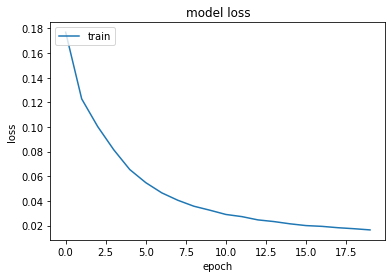

In [21]:
# Plotting the loss fetched from the History object returned by fit method
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

> **Checking the reconstruction of images performed by autoencoder**:

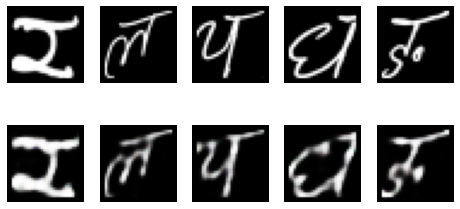

In [22]:
reconstruct_results(autoencoder, 'autoencoder', num_images=5, start=7)

> **Generating new samples using autoencoder**:

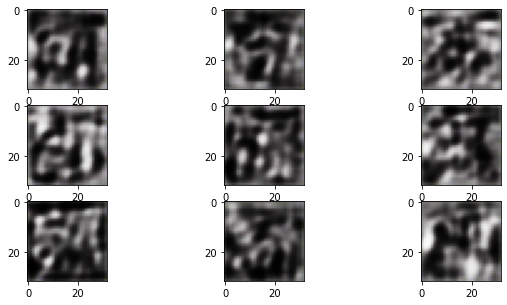

In [59]:
# Generating 9 samples using autoencoder's decoder
generate_images(decoder, 'autoencoder', latent_dim)

### Variational Auto-Encoder:

Explain what that is

> **Defining Sampling layer to be used by variational autoencoder**:

In [25]:
# Following code is taken from [7]
# Custom sampling layer used to get the latent space
class Sampling(keras.layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  def call(self, inputs):
    # override the inherited .call(self, inputs) method
    z_mean, z_log_var = inputs
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean)) # N(0, 1)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)

> **Defining build method for variational autoencoder specifying the network architecture**:

In [26]:
# Following code is a modified version of code taken from [7]
def build_vae(image_dim, latent_dim):
  
  # Encoder
  original_inputs = Input(shape=(image_dim), name="encoder_input")
  x = Conv2D(filters=16, kernel_size=(3,3), padding='same')(original_inputs)
  x = LeakyReLU()(x)
  x = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Flatten()(x)
  z_mean = Dense(latent_dim, name="z_mean")(x)
  z_log_var = Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()((z_mean, z_log_var))
  vae_encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

  # Decoder
  latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
  x = Dense(np.prod(image_dim))(latent_inputs)
  x = Reshape(image_dim)(x)
  x = Conv2DTranspose(filters=64, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2DTranspose(filters=32, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2DTranspose(filters=16, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  outputs = Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid')(x)  
  vae_decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")    

  # Define VAE model.
  outputs = vae_decoder(z)
  vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

  # Loss approach from
  # https://gist.github.com/tik0/6aa42cabb9cf9e21567c3deb309107b7  
  reconstruction_loss = mse(original_inputs, outputs) # xhat should match x
  reconstruction_loss = np.prod(image_dim) * K.mean(reconstruction_loss)
  kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

  # Setting up reconstruction and Kullback-Leibler regularisation losses on the model, 
  # and adding them as metrics for the model.
  # The Model's loss is the sum of the two losses.
  vae.add_loss(kl_loss)
  vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
  vae.add_loss(reconstruction_loss)
  vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

  return vae, vae_encoder, vae_decoder

> **Building and compiling the variational autoencoder**:

In [27]:
# Getting the models
vae, vae_encoder, vae_decoder = build_vae(image_dim, latent_dim)
# Setting the optimizer
vae_optimizer = keras.optimizers.Adam(1e-3)
# Compiling the variational autoencoder model
vae.compile(optimizer=vae_optimizer)

> **Printing model summaries**:

In [28]:
vae_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 16)   448         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 32, 32, 16)   0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 32)   4640        ['leaky_re_lu_6[0][0]']          
                                                                                            

In [29]:
vae_decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 3072)              310272    
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 3)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 64)       1792      
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                 

> **Training the variational autoencoder with Devanagari Handwritten Character dataset**:

In [30]:
# Training model and saving the returned History object in history
vae_history = vae.fit(x=dataset, y=dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 534.8518 - kl_loss: 19.9076 - mse_loss: 514.9442
Epoch 2/20
8/8 [==============================] - 19s 2s/step - loss: 339.5782 - kl_loss: 4.8470 - mse_loss: 334.7312
Epoch 3/20
8/8 [==============================] - 19s 2s/step - loss: 293.0214 - kl_loss: 1.9123 - mse_loss: 291.1092
Epoch 4/20
8/8 [==============================] - 19s 2s/step - loss: 260.0164 - kl_loss: 1.7818 - mse_loss: 258.2345
Epoch 5/20
8/8 [==============================] - 18s 2s/step - loss: 217.4426 - kl_loss: 2.8722 - mse_loss: 214.5704
Epoch 6/20
8/8 [==============================] - 19s 2s/step - loss: 181.1549 - kl_loss: 3.4309 - mse_loss: 177.7240
Epoch 7/20
8/8 [==============================] - 19s 2s/step - loss: 149.8348 - kl_loss: 3.6567 - mse_loss: 146.1781
Epoch 8/20
8/8 [==============================] - 19s 2s/step - loss: 125.9557 - kl_loss: 3.8437 - mse_loss: 122.1119
Epoch 9/20
8/8 [==============================] - 19s 2

> **Plotting the learning curve for variational autoencoder**:

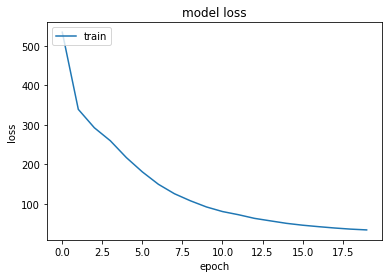

In [31]:
# Plotting the loss fetched from the History object returned by fit method
plt.plot(vae_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

> **Checking the reconstruction of images performed by variational autoencoder**:

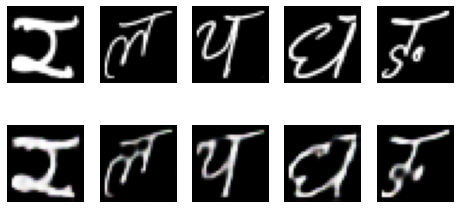

In [32]:
reconstruct_results(vae, 'vae', num_images=5, start=7)

> **Generating new samples using variational autoencoder**:

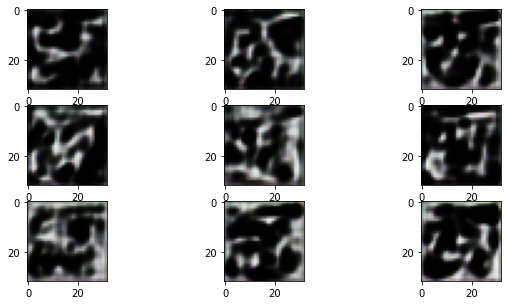

In [63]:
# Generating 9 samples using variational autoencoder's decoder
generate_images(vae_decoder, 'vae', latent_dim)

### Generative Adversarial Network:

explain what that is

> **Designing the generator architecture**:

In [34]:
def make_generator_model(image_dim, latent_dim):

    G = Sequential()
    G.add(InputLayer((latent_dim,)))
    G.add(Dense(np.prod(image_dim), use_bias=False)) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    G.add(Reshape(image_dim))
    G.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same'))
    G.add(LeakyReLU())
    G.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same'))
    G.add(LeakyReLU())
    G.add(Conv2DTranspose(filters=16, kernel_size=(3, 3), padding='same'))
    G.add(LeakyReLU())
    G.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid'))
    return G

> **Initializing the generator model and checking random image generation**:

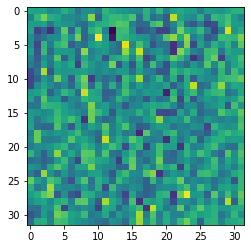

In [35]:
generator = make_generator_model(image_dim, latent_dim)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

> **Designing discriminator architecture**:

In [36]:
def make_discriminator_model(image_dim, latent_dim):
    
    D = Sequential()
    D.add(InputLayer(image_dim))
    D.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
    D.add(LeakyReLU())
    D.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
    D.add(LeakyReLU())
    D.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
    D.add(LeakyReLU())
    D.add(Flatten())
    D.add(Dense(1))

    return D

> **Using the discriminator model to identify if the image generated by the generator is real or fake**:


In [37]:
discriminator = make_discriminator_model(image_dim, latent_dim)
decision = discriminator(generated_image) # negative output for fake and positive output for real
print (decision)

tf.Tensor([[-0.08376011]], shape=(1, 1), dtype=float32)


> **Defining the losses for both generator and discriminator**:

In [38]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


> **Setting optimizers for generator and discriminator**:

In [39]:
generator_optimizer = keras.optimizers.Adam(1e-3)
discriminator_optimizer = keras.optimizers.Adam(1e-3)

In [40]:
# Saving checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

> **Defining the GAN training methods**:

In [41]:
num_examples_to_generate = 9

# Random sample to check training progress
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [42]:
# Using `tf.function` for compiling the train_step method.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [43]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [44]:
def generate_and_save_images(model, epoch, test_input):
  # `training` set to False to run all layers in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

> **Dataset preparation for training GAN with Devanagari Handwritten Character dataset**:

In [75]:
BUFFER_SIZE = len(dataset)

In [77]:
# Batching and shuffling the data using the common batch size and shuffling with entire data-set
gan_train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

> **Training the deep convolutional GAN with Devanagari Handwritten Character dataset**:

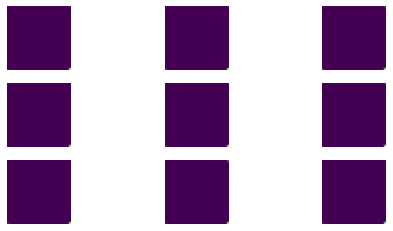

In [78]:
GAN_EPOCHS = 20
train(gan_train_dataset, GAN_EPOCHS)

In [54]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

> **Displaying images generated by GAN during training as a GIF**:

In [79]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
# !pip install git+https://github.com/tensorflow/docs


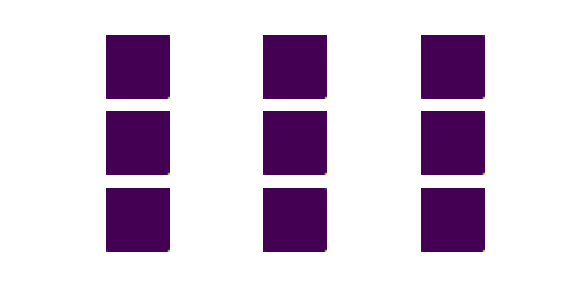

In [82]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

> **Generating new samples using the trained generator of deep convolutional GAN**:


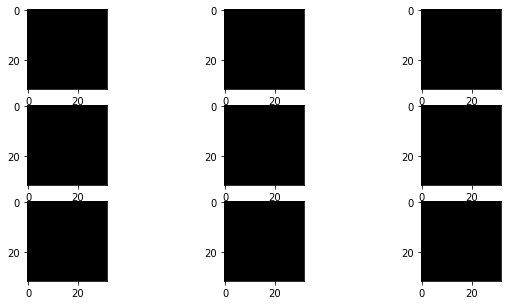

In [69]:
# Generating 9 samples using GAN's generator
generate_images(generator, 'gan', latent_dim)

## **Section 3: Results**

END

## References & Acknowledgements:

**Following resources were referred to perform the given tasks**,

[1] S. Acharya, A.K. Pant and P.K. Gyawali. Deep Learning Based Large Scale Handwritten Devanagari Character Recognition, In Proceedings of the 9th International Conference on Software, Knowledge, Information Management and Applications (SKIMA), pp. 121-126, 2015.

[2] Devanagari Handwritten Character Dataset Data Set. https://archive.ics.uci.edu/ml/datasets/Devanagari+Handwritten+Character+Dataset

[3] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

[4] Dr. M. Madden. (2021). Load and View CIFAR-10 Data.

[5] Dr. I. Ullah. (2022). ImageProcessing_CV.

[6] Dr. J. McDermott. (2022). Week 7 Lecture Material. Source Code: keras_mnist.py

[7] Dr. J. McDermott. (2022). Week 8 Lecture Material. Source Code: vae.py

[8] Ali Abdelaal. Autoencoders for Image Reconstruction in Python and Keras. Available at: https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/

[9] Dhanush Kamath. (2020). Generating New Faces With Variational Autoencoders. Available at: https://www.topbots.com/generating-new-faces-with-variational-autoencoders/

[10] How to display multiple images in one figure correctly? [duplicate]. (2021). Available at: https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645

[11] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). (2021). Available at: https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa

[12] Muhammad Ardi. (2020). Using Variational Autoencoder (VAE) to Generate New Images. Available at: https://becominghuman.ai/using-variational-autoencoder-vae-to-generate-new-images-14328877e88d

[13] Deep Convolutional Generative Adversarial Network. Available at: https://www.tensorflow.org/tutorials/generative/dcgan